In [1]:
import os
import os.path as osp
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from PIL import Image
import tqdm
import shutil
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

In [2]:
groundtruth = pd.read_csv("./GroundTruth.csv")
meta = pd.read_csv("./Metadata.csv")
data = meta.merge(groundtruth, how='inner', on='image').sample(frac=1).reset_index(drop=True)
data["target"] = data.apply(lambda x: np.argmax(x[["MEL", "NV", "BCC", "AK", "BKL", "DF", "VASC", "SCC"]]), axis=1)
classes = ["MEL", "NV", "BCC", "AK", "BKL", "DF", "VASC", "SCC"]
classesLabel = dict((i,ele) for i, ele in enumerate(classes))

In [3]:
groundtruth.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
meta.head()

,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male


In [5]:
data.head()

,image,age_approx,anatom_site_general,lesion_id,sex,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,target
0,ISIC_0069150,40.0,anterior torso,BCN_0005703,female,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,ISIC_0064196,65.0,head/neck,BCN_0005212,female,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3
2,ISIC_0033173,40.0,NaN,HAM_0003813,male,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,ISIC_0026612,45.0,lower extremity,HAM_0006561,female,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,ISIC_0054725,50.0,anterior torso,BCN_0000970,male,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [6]:
def center_crop(pil_img):
    img_width, img_height = pil_img.size
    if img_width > img_height:
        crop_size = img_height
    else:
        crop_size = img_width
    return pil_img.crop(((img_width - crop_size) // 2,
                         (img_height - crop_size) // 2,
                         (img_width + crop_size) // 2,
                         (img_height + crop_size) // 2))

In [7]:
# data loader
images = []
labels = []
for imageName, target in zip(data['image'], data['target']):
    try:
        image = Image.open("./FinalDatasets/" + imageName + '.jpg').resize((227,227))
    except:
        continue
    images.append(np.asarray(center_crop(image)))
    labels.append(target)

In [8]:
# list to numpy conversion
images = np.array(images)
labels = np.array(labels)

In [9]:
images.shape

(5983, 227, 227, 3)

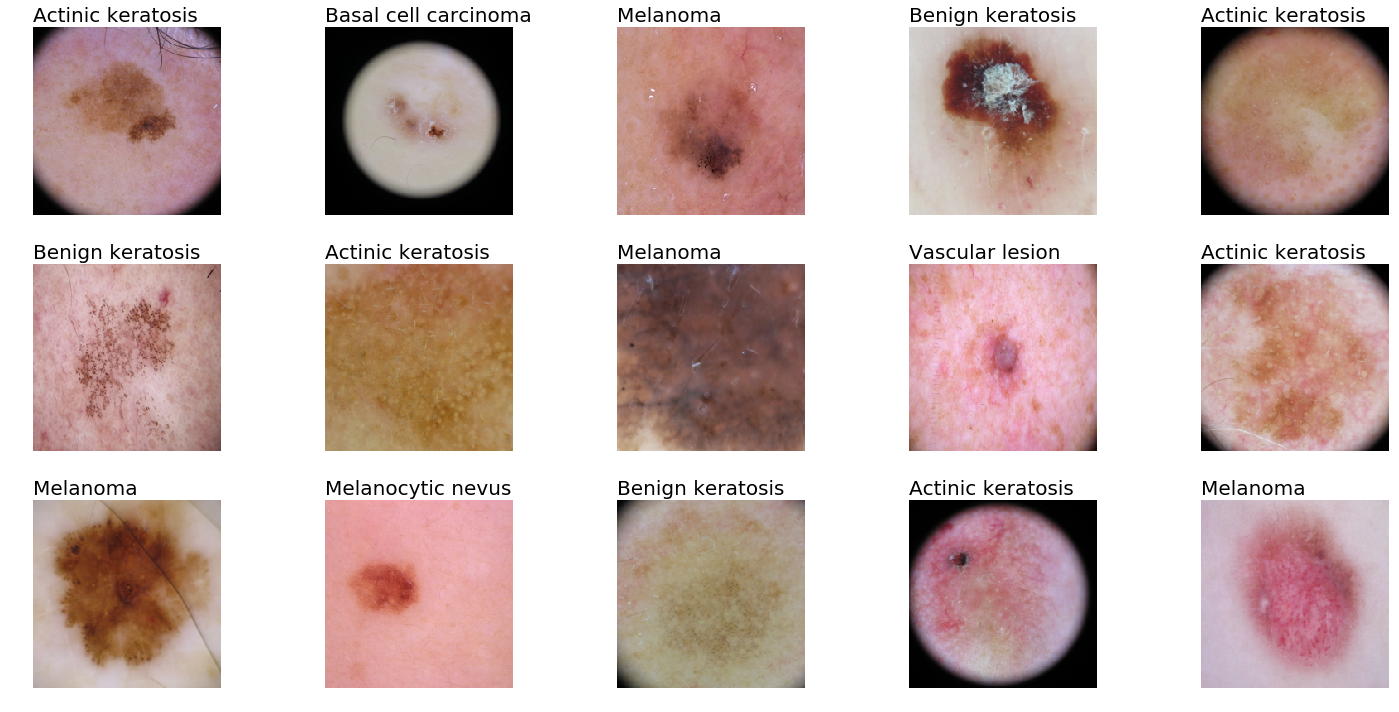

In [10]:
# data visualisation
classesName = [ 'Melanoma', 'Melanocytic nevus','Basal cell carcinoma', 'Actinic keratosis', 'Benign keratosis','Dermatofibroma','Vascular lesion','Squamous cell carcinoma']

fig = plt.figure(figsize=(20, 10))
position = 0
for image,label in zip(images, labels):
    if position == 15:
        break
    plt.subplot(3,5,position+1)
    plt.imshow(image)
    plt.title(classesName[label], loc='left', size=20)
    plt.axis('off')
    position += 1

plt.tight_layout()
plt.show()

In [13]:
images = images[:300]
labels = labels[:300]

In [14]:
# spiltting datasets
xtrain,xtest,ytrain,ytest = train_test_split(images, labels, test_size=0.2)

In [15]:
# train and test data size
print(xtrain.shape, xtest.shape)

(240, 227, 227, 3) (60, 227, 227, 3)


In [20]:
# Creating a Sequential model
model = Sequential()

model.add(Conv2D(filters=96, kernel_size=(11,11), input_shape=(227, 227, 3), strides=(4,4), padding='valid'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((3,3), strides=(2,2), padding='valid'))

model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((3,3), strides=(2,2), padding='valid'))

model.add(Conv2D(filters=384, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(filters=384, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((3,3), strides=(2,2), padding='valid'))

model.add(Flatten())

model.add(Dense(4096))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(4096))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(len(classes)))
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_v1_7 (Ba (None, 55, 55, 96)        384       
_________________________________________________________________
activation_8 (Activation)    (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
batch_normalization_v1_8 (Ba (None, 27, 27, 256)       1024      
_________________________________________________________________
activation_9 (Activation)    (None, 27, 27, 256)       0         
__________

In [21]:
opt = Adam()
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
ytrain_binary = to_categorical(ytrain)
ytest_binary = to_categorical(ytest)

In [23]:
trainedModel = model.fit(xtrain,ytrain_binary, validation_data=(xtest, ytest_binary), epochs=20, batch_size=64)

Train on 240 samples, validate on 60 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
240/240 [==============================] - 33s 139ms/sample - loss: 2.6575 - acc: 0.1792 - val_loss: 13.4317 - val_acc: 0.1667
Epoch 2/20
240/240 [==============================] - 23s 95ms/sample - loss: 2.4161 - acc: 0.2833 - val_loss: 13.4317 - val_acc: 0.1667
Epoch 3/20
240/240 [==============================] - 19s 78ms/sample - loss: 1.9692 - acc: 0.3042 - val_loss: 13.9690 - val_acc: 0.1333
Epoch 4/20
240/240 [==============================] - 18s 77ms/sample - loss: 1.8862 - acc: 0.3333 - val_loss: 13.9690 - val_acc: 0.1333
Epoch 5/20
240/240 [==============================] - 19s 79ms/sample - loss: 1.7241 - acc: 0.3458 - val_loss: 13.9690 - val_acc: 0.1333
Epoch 6/20
240/240 [==============================] - 19s 80ms/sample - loss: 1.7648 - acc: 0.3458 - val_loss: 13.9690 - val_acc: 0.1333
Epoch 7/20
240/240 [==============================] - 18s 75ms/sample - loss: 1.6632

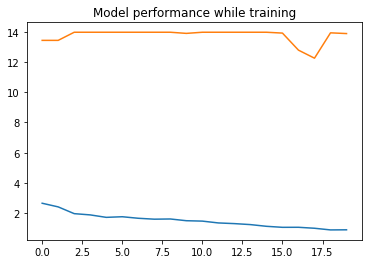

In [28]:
train_loss = trainedModel.history['loss']
val_loss   = trainedModel.history['val_loss']
train_acc  = trainedModel.history['acc']
val_acc    = trainedModel.history['val_acc']
xc         = range(20)
 
plt.figure()
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.title("Model performance while training")
plt.show()

In [29]:
model.evaluate(xtest, ytest_binary, verbose=1)

60/60 [==============================] - 3s 53ms/sample - loss: 2.9551 - acc: 0.0833


[2.9550761381785073, 0.083333336]

In [30]:
testImage = "./FinalDatasets/ISIC_0015160_downsampled.jpg"
image = Image.open(testImage).resize((227,227))
image = np.asarray(center_crop(image))

In [31]:
pred = model.predict_classes(image.reshape(-1, 227,227,3))

Label : AK
Skin Lesion Name : Actinic keratosis


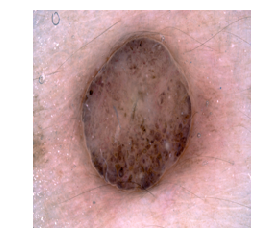

In [37]:
className = classes[pred[0]]
plt.imshow(Image.fromarray(image))
plt.axis('off')
print('Label :',className)
print('Skin Lesion Name :',classesName[pred[0]])